# Stock exchange prediction for fun

Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns


Read and prepare OHLC data, 5 minute bars

In [228]:
# Read 1M OHLCV data from file instead of pdr.DataReader('RTSI','moex',start,end) because moex network source doesn't allow often downloads
df=pd.read_csv("/home/dima/projects/stockpredict/data/RI.RTSI_180101_180313.csv", 
               parse_dates={'datetime':[2,3]}, 
               index_col='datetime')
#df=df.loc['2018-01-09']
df=df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']]
df.columns=['open','high','low','close','vol']
# Resample 1Min OHLC to 5Min OHLC
df=df.resample('5Min').agg({
        'open': 'first', 
        'high': 'max', 
        'low': 'min', 
        'close': 'last',
        'vol': 'sum'})
df=df.dropna()
df.tail()

,open,high,low,close,vol
datetime,,,,,
2018-03-13 18:25:00,1282.69,1283.14,1281.92,1282.12,11017460
2018-03-13 18:30:00,1282.06,1285.36,1282.06,1284.80,12692191
2018-03-13 18:35:00,1284.80,1284.80,1282.52,1283.14,12809211
2018-03-13 18:40:00,1283.20,1283.46,1282.92,1283.21,3378532
2018-03-13 18:50:00,1285.80,1285.80,1285.80,1285.80,31243913


Prepare predictors from rolling window. Add previous records as columns to the right


In [229]:
predictors=df.reset_index().drop(['datetime'],axis=1)
target=predictors.shift(-1)[['high','low']][:-1]
predictors=predictors[:-1]


In [230]:
predictors.tail()

,open,high,low,close,vol
4886,1281.54,1282.89,1281.47,1282.68,11307910
4887,1282.69,1283.14,1281.92,1282.12,11017460
4888,1282.06,1285.36,1282.06,1284.80,12692191
4889,1284.80,1284.80,1282.52,1283.14,12809211
4890,1283.20,1283.46,1282.92,1283.21,3378532


In [231]:
target.tail()

,high,low
4886,1283.14,1281.92
4887,1285.36,1282.06
4888,1284.80,1282.52
4889,1283.46,1282.92
4890,1285.80,1285.80


Predict with neural network

In [247]:
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.3, shuffle=False)

# Create the model
model=Sequential()
n_cols = predictors.shape[1]
##model.add(Dense(predictors.columns.size, activation='relu', input_shape=(n_cols,10)))
model.add(Dense(predictors.columns.size, batch_size=10))
model.add(Dense(int(predictors.columns.size), activation='relu'))
# High/Low prediction output
model.add(Dense(2))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Fit
#early_stopping = EarlyStopping(patience=2)
#model.fit(X_train.values, y_train.values, validation_split=0.3, epochs=30, callbacks=[early_stopping], shuffle=False, verbose=True)
model.fit(X_train.values, y_train.values, validation_split=0.3, epochs=20, shuffle=True, verbose=True)

# Predict
y=model.predict(X_test)

Train on 2396 samples, validate on 1027 samples
Epoch 1/20
2396/2396 [==============================] - 1s 434us/step - loss: 4737102590847.7861 - acc: 1.0000 - val_loss: 759559422015.8131 - val_acc: 1.0000
Epoch 2/20
2396/2396 [==============================] - 0s 37us/step - loss: 232472341534.7713 - acc: 1.0000 - val_loss: 11351354006.0604 - val_acc: 1.0000
Epoch 3/20
2396/2396 [==============================] - 0s 36us/step - loss: 27464473690.7112 - acc: 0.2679 - val_loss: 4995569420.2142 - val_acc: 9.7371e-04
Epoch 4/20
2396/2396 [==============================] - 0s 36us/step - loss: 6976610358.4374 - acc: 0.6127 - val_loss: 2850869707.6534 - val_acc: 1.0000
Epoch 5/20
2396/2396 [==============================] - 0s 37us/step - loss: 1566829268.7579 - acc: 0.7496 - val_loss: 1164645091.2093 - val_acc: 9.7371e-04
Epoch 6/20
2396/2396 [==============================] - 0s 37us/step - loss: 1259234036.4891 - acc: 0.4386 - val_loss: 1116303479.7741 - val_acc: 1.0000
Epoch 7/20
2396/

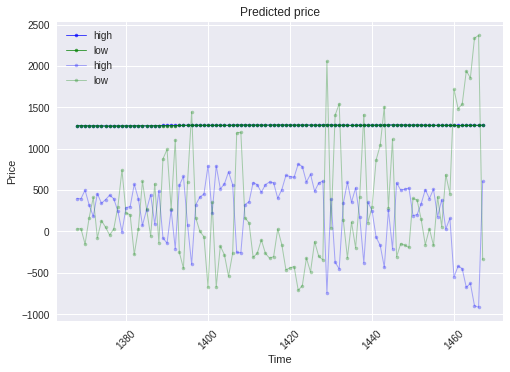

In [245]:


#from mpl_finance import candlestick_ohlc
plt.style.use('seaborn')
#fig,ax = plt.subplots()
#quotes=df.reset_index()
#quotes.columns=['date','open','high','low','close','vol']
#quotes=quotes[['date','open','high','low','close']]
#quotes['date'] = quotes['date'].apply(mdates.date2num)
#candlestick_ohlc(ax,quotes.values, width=.001, colorup='blue', colordown='green')
#candlestick_ohlc(ax,quotes.values, width=.03, alpha=0.5, colorup='black', colordown='red')

#plt.plot(df.index, df.high, marker='.', linestyle='solid', color='b', alpha=0.5, linewidth=1)
#plt.plot(df.index, df.low, marker='.', linestyle='solid', color='green', alpha=0.5, linewidth=1)
last_points=100
original=pd.DataFrame(y_test).reset_index()[-last_points:]
plt.plot(original['high'], marker='.', linestyle='solid', color='b', alpha=0.7, linewidth=1)
plt.plot(original['low'], marker='.', linestyle='solid', color='green', alpha=0.7, linewidth=1)

actual=pd.DataFrame(y, columns=['high','low']).reset_index()[-last_points:]
plt.plot(actual['high'], marker='.', linestyle='solid', color='b', alpha=0.3, linewidth=1)
plt.plot(actual['low'], marker='.', linestyle='solid', color='green', alpha=0.3, linewidth=1)

#plt.ylim(min(original['high']),max(original['high']))

plt.title('Predicted price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.legend()
plt.show()

The first result looks not very encouraging, doesn't it? :)

.. To be continue ...